In [1]:
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import parallel_backend
import pandas as pd
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    GridSearchCV,
    cross_val_score,
    TimeSeriesSplit
)
from sklearn.linear_model import (
    LassoCV, 
    LinearRegression
) 
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    AdaBoostRegressor, 
    ExtraTreesRegressor, 
    StackingRegressor,
    VotingRegressor
)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    RobustScaler
)

# from catboost import CatBoostRegressor
# import lightgbm as lgb

In [2]:
data = pd.read_csv(r'C:\Users\xBaka\Notebooks\School\Project\used\train_2015.csv')
data['month'] = pd.to_datetime(data['month'])
data['month'] = pd.Categorical(data['month']).codes ## month-1 = 2015-01-01, month-71 = 2020-12-01
data = data.sort_values(by='month').reset_index(drop=True)
data

,month,floor_area_sqm,remaining_lease,MRT_distance,Mall_distance,Market_distance,Hawker_distance,CBD_distance,flat_type_1 ROOM,flat_type_2 ROOM,...,district_18,district_19,district_20,district_21,district_22,district_23,district_25,district_27,district_28,target
0,0,88.0,84,0.994266,0.808769,0.047046,0.185346,6.376045,0,0,...,0,0,1,0,0,0,0,0,0,259120.206490
1,0,84.0,69,0.200669,0.126336,0.121189,0.056087,2.210677,0,0,...,0,0,0,0,0,0,0,0,0,239675.516224
2,0,74.0,67,0.210231,0.154911,0.228448,0.025700,2.679047,0,0,...,0,0,0,0,0,0,0,0,0,221238.938053
3,0,84.0,70,0.262545,0.202888,0.204460,0.308133,2.594427,0,0,...,0,0,0,0,0,0,0,0,0,243362.831858
4,0,104.0,72,0.248533,0.203753,0.091573,0.012464,3.150545,0,0,...,0,0,0,0,0,0,0,0,0,247050.147493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122846,71,46.0,93,0.049306,0.610338,0.058236,1.216475,15.114255,0,1,...,0,0,0,0,0,0,1,0,0,183924.692252
122847,71,46.0,93,0.049306,0.610338,0.058236,1.216475,15.114255,0,1,...,0,0,0,0,0,0,1,0,0,181752.353367
122848,71,148.0,62,0.364824,0.184935,0.208555,1.903213,10.007279,0,0,...,0,1,0,0,0,0,0,0,0,474293.989862
122849,71,93.0,63,0.404561,0.333974,0.138210,0.237594,2.709955,0,0,...,0,0,0,0,0,0,0,0,0,278783.490224


In [3]:
print("Resale price standard deviation:", np.std(data['target']))

Resale price standard deviation: 111557.94061028656


In [4]:
# plt.figure(figsize=(10,15))
# for i, feature in enumerate(['floor_area_sqm', 'remaining_lease', 'MRT_distance', 'Mall_distance', 'Hawker_distance', 'CBD_distance', 'target']):
#     plt.subplot(4, 2, i+1)
#     sns.scatterplot(x=data['month'], y=data[feature])
# plt.show()

# Data windowing

Important to split by the months, do not want contamination through the months.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [5]:
data = data.set_index('month')
X = data.drop('target', axis=1)
y = np.log1p(data['target'])

X, X_test, y, y_test = train_test_split(X, y, test_size=0.5, shuffle=False, random_state=42)

X_test = X_test.reset_index()
y_test = y_test.reset_index(drop=True)

print("X shape:", X.shape)
print("X_test shape:", X_test.shape)

X shape: (61425, 42)
X_test shape: (61426, 43)


In [6]:
def model_training(algorithm):
    i = 0
    scores = []
    n_splits = 10
    print('Training start...')

    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_idx, val_idx in tscv.split(X, y):
        i += 1   
        X_train = X.iloc[train_idx, :].reset_index()
        X_val = X.iloc[val_idx, :].reset_index()
        y_train = y.iloc[train_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        y_true_test = y_test

        # for feature in ['floor_area_sqm', 'remaining_lease']:
        #     scaler = MinMaxScaler().fit(X_train[[feature]])
        #     X_train[feature] = scaler.transform(X_train[[feature]])
        #     X_val[feature] = scaler.transform(X_val[[feature]])
        #     X_test[feature] = scaler.transform(X_test[[feature]])

        start_time = time.time()

        with parallel_backend('threading'):
            model = algorithm.fit(X_train, y_train)

        end_time = time.time()

        y_pred_train = np.log1p(model.predict(X_train))
        y_pred_val = np.log1p(model.predict(X_val))
        y_pred_test = np.log1p(model.predict(X_test))

        train_rmse = np.exp(mean_squared_error(y_train, y_pred_train, squared=False)).round(4)
        val_rmse = np.exp(mean_squared_error(y_val, y_pred_val, squared=False)).round(4)
        test_rmse = np.exp(mean_squared_error(y_true_test, y_pred_test, squared=False)).round(4)

        time_elapsed = round(end_time-start_time, 3)
        print(f"Fold {i}: Train RMSE = {train_rmse}, Val RMSE = {val_rmse}, Test RMSE = {test_rmse} Time elapsed = {time_elapsed}s")
        scores.append([train_rmse, val_rmse, test_rmse])
        
    scores = pd.DataFrame(scores, columns=['train_rmse', 'val_rmse', 'test_rmse'])

    plt.figure(figsize=(10,5))
    sns.lineplot(x=scores.index, y=scores['train_rmse'], label='train_rmse')
    sns.lineplot(x=scores.index, y=scores['val_rmse'], label='val_rmse')
    sns.lineplot(x=scores.index, y=scores['test_rmse'], label='test_rmse')
    plt.xticks(range(n_splits))
    plt.xlabel('folds'); plt.ylabel('scores')
    plt.show()
    return model

Training start...
Fold 1: Train RMSE = 22682.3428, Val RMSE = 22695.6797, Test RMSE = 23220.6904 Time elapsed = 0.012s
Fold 2: Train RMSE = 22692.2811, Val RMSE = 22731.9784, Test RMSE = 23338.9889 Time elapsed = 0.017s
Fold 3: Train RMSE = 22705.2618, Val RMSE = 23041.3617, Test RMSE = 23343.5427 Time elapsed = 0.024s
Fold 4: Train RMSE = 22785.3885, Val RMSE = 22958.1314, Test RMSE = 23296.9048 Time elapsed = 0.033s
Fold 5: Train RMSE = 22819.8956, Val RMSE = 22943.3508, Test RMSE = 23294.1441 Time elapsed = 0.04s
Fold 6: Train RMSE = 22840.2998, Val RMSE = 23060.8697, Test RMSE = 23296.7492 Time elapsed = 0.049s
Fold 7: Train RMSE = 22871.3875, Val RMSE = 23269.9213, Test RMSE = 23295.812 Time elapsed = 0.058s
Fold 8: Train RMSE = 22919.6734, Val RMSE = 23327.8665, Test RMSE = 23276.428 Time elapsed = 0.081s
Fold 9: Train RMSE = 22965.3488, Val RMSE = 23475.5108, Test RMSE = 23280.9803 Time elapsed = 0.079s
Fold 10: Train RMSE = 23015.7838, Val RMSE = 23723.7456, Test RMSE = 23282.4

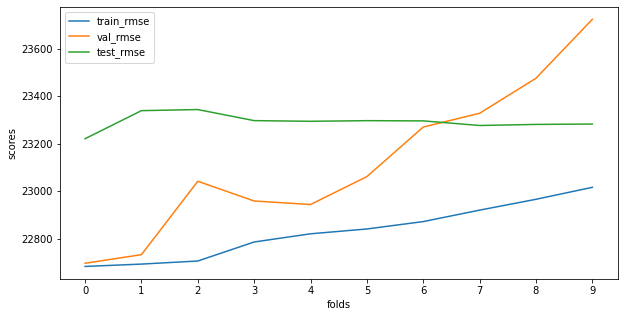

In [7]:
lr = model_training(LinearRegression())

Training start...
Fold 1: Train RMSE = 22679.385, Val RMSE = 22705.1163, Test RMSE = 23264.7402 Time elapsed = 0.057s
Fold 2: Train RMSE = 22689.3135, Val RMSE = 22721.916, Test RMSE = 23236.2435 Time elapsed = 0.109s
Fold 3: Train RMSE = 22702.2488, Val RMSE = 23037.9938, Test RMSE = 23216.9962 Time elapsed = 0.169s
Fold 4: Train RMSE = 22782.2487, Val RMSE = 22943.4853, Test RMSE = 23220.3693 Time elapsed = 0.235s
Fold 5: Train RMSE = 22816.7067, Val RMSE = 22920.6114, Test RMSE = 23206.499 Time elapsed = 0.297s
Fold 6: Train RMSE = 22837.047, Val RMSE = 23038.6026, Test RMSE = 23205.2066 Time elapsed = 0.352s
Fold 7: Train RMSE = 22868.0581, Val RMSE = 23251.9504, Test RMSE = 23230.5287 Time elapsed = 0.419s
Fold 8: Train RMSE = 22916.2452, Val RMSE = 23302.2221, Test RMSE = 23219.3458 Time elapsed = 0.47s
Fold 9: Train RMSE = 22961.8206, Val RMSE = 23448.9205, Test RMSE = 23252.292 Time elapsed = 0.557s
Fold 10: Train RMSE = 23012.1595, Val RMSE = 23703.0376, Test RMSE = 23248.604 

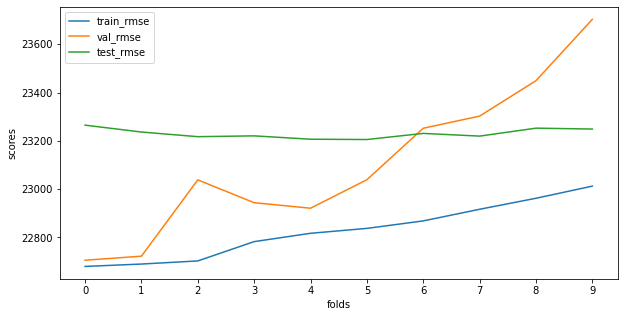

In [8]:
tree = model_training(DecisionTreeRegressor())

Training start...
Fold 1: Train RMSE = 22678.8524, Val RMSE = 22692.9447, Test RMSE = 23240.418 Time elapsed = 0.605s
Fold 2: Train RMSE = 22688.7569, Val RMSE = 22718.0434, Test RMSE = 23232.2828 Time elapsed = 1.097s
Fold 3: Train RMSE = 22701.9577, Val RMSE = 23024.017, Test RMSE = 23225.9349 Time elapsed = 1.654s
Fold 4: Train RMSE = 22781.9378, Val RMSE = 22939.7195, Test RMSE = 23217.6753 Time elapsed = 2.106s
Fold 5: Train RMSE = 22816.2504, Val RMSE = 22920.4645, Test RMSE = 23216.3832 Time elapsed = 2.751s
Fold 6: Train RMSE = 22836.6778, Val RMSE = 23034.5886, Test RMSE = 23210.3756 Time elapsed = 2.984s
Fold 7: Train RMSE = 22867.789, Val RMSE = 23239.6642, Test RMSE = 23220.9561 Time elapsed = 3.649s
Fold 8: Train RMSE = 22916.0458, Val RMSE = 23293.9465, Test RMSE = 23219.2016 Time elapsed = 4.469s
Fold 9: Train RMSE = 22961.5879, Val RMSE = 23450.3835, Test RMSE = 23239.5738 Time elapsed = 4.859s
Fold 10: Train RMSE = 23012.0616, Val RMSE = 23697.1714, Test RMSE = 23244.8

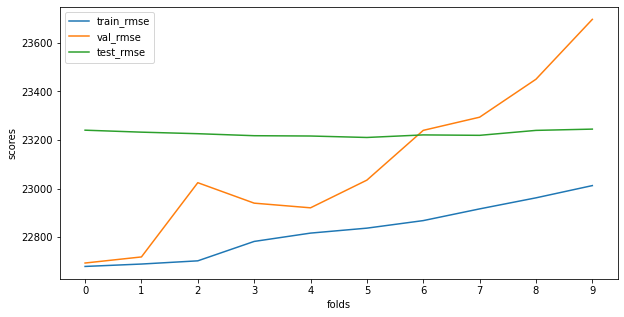

In [9]:
forest = model_training(RandomForestRegressor())

Training start...
Fold 1: Train RMSE = 22679.385, Val RMSE = 22710.7433, Test RMSE = 23242.1341 Time elapsed = 0.464s
Fold 2: Train RMSE = 22689.3135, Val RMSE = 22719.3103, Test RMSE = 23218.758 Time elapsed = 0.723s
Fold 3: Train RMSE = 22702.2488, Val RMSE = 23028.2412, Test RMSE = 23210.8192 Time elapsed = 1.045s
Fold 4: Train RMSE = 22782.2487, Val RMSE = 22945.0185, Test RMSE = 23208.2872 Time elapsed = 1.277s
Fold 5: Train RMSE = 22816.7067, Val RMSE = 22925.7029, Test RMSE = 23204.8537 Time elapsed = 1.649s
Fold 6: Train RMSE = 22837.047, Val RMSE = 23047.3203, Test RMSE = 23215.5281 Time elapsed = 2.03s
Fold 7: Train RMSE = 22868.0581, Val RMSE = 23247.3532, Test RMSE = 23226.8513 Time elapsed = 2.331s
Fold 8: Train RMSE = 22916.2452, Val RMSE = 23309.8437, Test RMSE = 23225.3446 Time elapsed = 2.732s
Fold 9: Train RMSE = 22961.8206, Val RMSE = 23458.8757, Test RMSE = 23240.0145 Time elapsed = 3.102s
Fold 10: Train RMSE = 23012.1595, Val RMSE = 23706.2901, Test RMSE = 23248.25

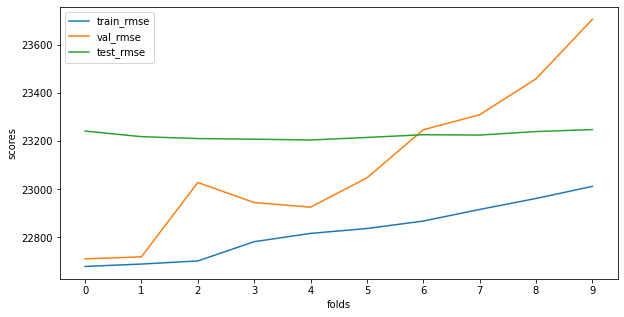

In [10]:
extra_trees = model_training(ExtraTreesRegressor())

Training start...
Fold 1: Train RMSE = 22681.282, Val RMSE = 22727.5487, Test RMSE = 23240.1224 Time elapsed = 0.971s
Fold 2: Train RMSE = 22691.3434, Val RMSE = 22721.7465, Test RMSE = 23222.8025 Time elapsed = 1.949s
Fold 3: Train RMSE = 22704.3182, Val RMSE = 23027.0138, Test RMSE = 23226.6848 Time elapsed = 2.872s
Fold 4: Train RMSE = 22784.4378, Val RMSE = 22951.8034, Test RMSE = 23222.5304 Time elapsed = 3.762s
Fold 5: Train RMSE = 22818.9748, Val RMSE = 22930.3563, Test RMSE = 23229.0533 Time elapsed = 4.702s
Fold 6: Train RMSE = 22839.3749, Val RMSE = 23050.5714, Test RMSE = 23235.7303 Time elapsed = 5.69s
Fold 7: Train RMSE = 22870.4633, Val RMSE = 23260.0861, Test RMSE = 23239.4432 Time elapsed = 6.586s
Fold 8: Train RMSE = 22918.7528, Val RMSE = 23318.7766, Test RMSE = 23242.2499 Time elapsed = 7.527s
Fold 9: Train RMSE = 22964.4219, Val RMSE = 23464.1567, Test RMSE = 23248.5603 Time elapsed = 8.442s
Fold 10: Train RMSE = 23014.8436, Val RMSE = 23708.8144, Test RMSE = 23251.

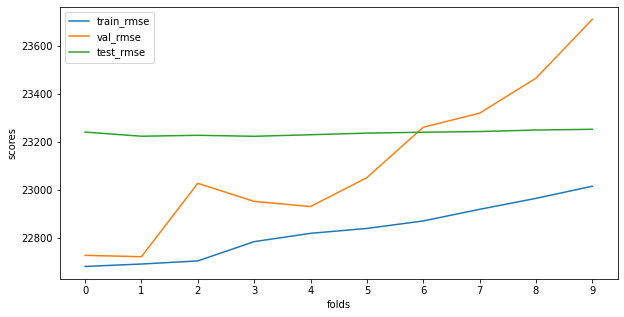

In [11]:
xgb = model_training(GradientBoostingRegressor(
    random_state=42
))

In [12]:
models = [xgb, extra_trees, lr, tree, forest]

results = []
for model in models:
    print(model)
    y_true = y_test
    y_pred = np.log1p(model.predict(X_test))
    rmse = np.exp(mean_squared_error(y_true, y_pred, squared=False)).round(4)
    results.append(rmse)
    print(rmse)

print("Ensemble results:", np.mean(results))

GradientBoostingRegressor(random_state=42)
23251.5959
ExtraTreesRegressor()
23248.2554
LinearRegression()
23282.4925
DecisionTreeRegressor()
23248.604
RandomForestRegressor()
23244.8204
Ensemble results: 23255.153639999997


In [13]:
# # Save model
# filename = 'xgb_model.sav'
# joblib.dump(xgb, filename)

In [14]:
# # Load model
# path = os.path.join("", filename)
# load_model = joblib.load(path)
# result = load_model.score(X_test, y_test)
# print(result)